In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.optimize as opt
%matplotlib inline

## Exercise 1

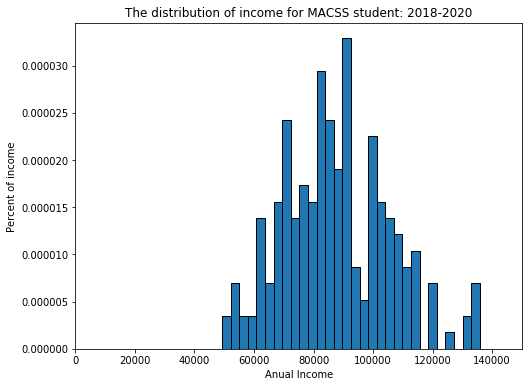

In [2]:
#a) A histogram of income
income = np.loadtxt("./data/incomes.txt")
num_bins = 30
plt.figure(figsize = (8,6))
plt.title("The distribution of income for MACSS student: 2018-2020")
plt.xlabel("Anual Income")
plt.ylabel("Percent of income")
plt.xlim([0, 150000]) 
count, bins, ignored = plt.hist(income, num_bins, density=True, edgecolor='k')

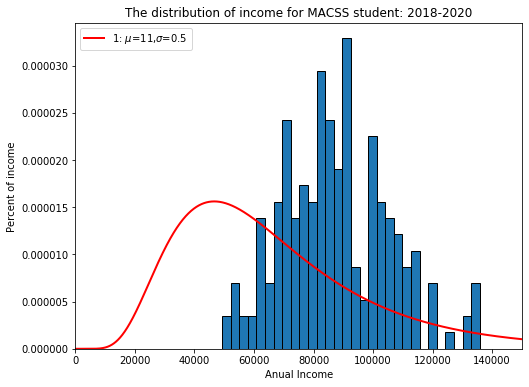

In [3]:
#b) Plot a log normal distribution
#Define a function that returns the log norm probablility of a set of x points
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma, scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu)))
            
    pdf_vals = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

#Now plot the log normal pdf
num_bins = 30
plt.figure(figsize = (8,6))
plt.title("The distribution of income for MACSS student: 2018-2020")
plt.xlabel("Anual Income")
plt.ylabel("Percent of income")
plt.xlim([0, 150000]) 
count, bins, ignored = plt.hist(income, num_bins, density=True, edgecolor='k')

dist_income = np.linspace(1, 150000, 2000)
mu_1 = 11
sig_1 = 0.5
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_1, sig_1, 0, 150000),
         linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

In [4]:
def log_lik_trunclognorm(xvals, mu, sigma, cut_lb, cut_ub):
    pdf_vals = trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print("Log likelihood 1:", log_lik_trunclognorm(income, mu_1, sig_1, 0, 150000))

Log likelihood 1: -2379.120591931827


In [5]:
#c) Estimate the parameters of lognormal distribution by maximum likelihood
def crit(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub = args
    log_lik_val = log_lik_trunclognorm(xvals, mu, abs(sigma), cut_lb, cut_ub)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

mu_init = 11  # mu_2
sig_init = 0.5  # sig_2
params_init = np.array([mu_init, sig_init])
mle_args = (income, 0, 150000)
results_uncstr = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE, sig_MLE = results_uncstr.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)

mu_MLE= 11.361699976195325  sig_MLE= 0.21174326387580453


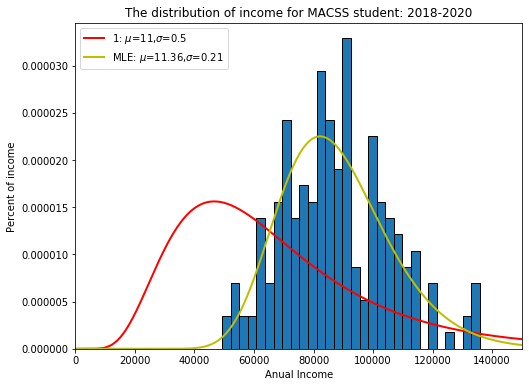

In [6]:
#Then plot the maximum likelihood pdf on the oringinal figure
num_bins = 30
plt.figure(figsize = (8,6))
plt.title("The distribution of income for MACSS student: 2018-2020")
plt.xlabel("Anual Income")
plt.ylabel("Percent of income")
plt.xlim([0, 150000]) 
count, bins, ignored = plt.hist(income, num_bins, density=True, edgecolor='k')

dist_pts = np.linspace(1, 150000, 2000)
#Pdf from (b)
mu_1 = 11
sig_1 = 0.5
plt.plot(dist_pts, trunc_lognorm_pdf(dist_income, mu_1, sig_1, 0, 150000),
         linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')
#Pdf of ML
plt.plot(dist_pts, trunc_lognorm_pdf(dist_income, mu_MLE, sig_MLE, 0, 150000),
         linewidth=2, color='y', label='MLE: $\mu$=11.36,$\sigma$=0.21')
plt.legend(loc='upper left')

In [7]:
#The log likelihood of MLE estimates
print("Log likelihood MLE:", log_lik_trunclognorm(income, mu_MLE, sig_MLE, 0, 150000))

Log likelihood MLE: -2240.934337511636


In [8]:
vcv_mle = results_uncstr.hess_inv

stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)
print('mu percent', stderr_mu_mle/mu_MLE)
print('sig percent', stderr_sig_mle/sig_MLE)

VCV(MLE) =  [[2.91537336e-04 4.85795633e-05]
 [4.85795633e-05 1.25900074e-04]]
Standard error for mu estimate =  0.01707446443246779
Standard error for sigma estimate =  0.011220520201776097
mu percent 0.001502808951850662
sig percent 0.05299115540392047


In [9]:
#d) The ratio test for part (b)
mu_new, sig_new = np.array([11, 0.5])
log_lik_h0 = log_lik_trunclognorm(income, mu_new, sig_new, 0, 150000)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_trunclognorm(income, mu_MLE, sig_MLE, 0, 150000)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2379.120591931827
MLE log likelihood -2240.934337511636
likelihood ratio value 276.3725088403826
chi squared of H0 with 2 degrees of freedom p-value =  0.0


In [10]:
#e) The probability of income over a certain level
prob1 = 1 - sts.lognorm.cdf(100000, s=sig_MLE, scale=np.exp(mu_MLE))
prob2 = sts.lognorm.cdf(75000, s=sig_MLE, scale=np.exp(mu_MLE))
print("The probability that income is over $100,000:", prob1)
print("The probability that income is less than $75,000:", prob2)

The probability that income is over $100,000: 0.23755402178770746
The probability that income is less than $75,000: 0.25964392133742675


## Exercise 2

In [11]:
#a) Estimate the parameters of the model using maximum likelihood
sick_df = pd.read_csv("./data/sick.txt")
sick_df

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90
...,...,...,...,...
195,0.53,30.56,0.74,41.76
196,0.86,33.97,1.40,39.10
197,1.39,44.00,2.45,40.95
198,0.72,22.30,1.03,23.14


In [12]:
def log_lik(y, x1, x2, x3, beta_0, beta_1, beta_2, beta_3, sigma):
    epsilon = y - beta_0 - beta_1 * x1 - beta_2 * x2 - beta_3 * x3
    pdf_vals = sts.norm.pdf(epsilon, loc=0.0, scale=sigma)
    log_lik_func = np.log(pdf_vals).sum()
    
    return log_lik_func

def crit_lr(params, *args):
    beta_0, beta_1, beta_2, beta_3, sigma = params
    y, x1, x2, x3 = args
    neg_log_lik = -log_lik(y, x1, x2, x3, beta_0, beta_1, beta_2, beta_3, sigma)
    
    return neg_log_lik

beta_0_init = 0.3
beta_1_init = 0
beta_2_init = 0
beta_3_init = 0
sigma_init = 1
params_init = np.array([beta_0_init, beta_1_init, beta_2_init, beta_3_init, sigma_init])
args_lr = (sick_df['sick'], sick_df['age'], sick_df['children'], sick_df['avgtemp_winter'])
results = opt.minimize(crit_lr, params_init, args=(args_lr))
beta_0_MLE, beta_1_MLE, beta_2_MLE, beta_3_MLE, sigma_MLE = results.x

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [13]:
print("beta_0 = ", beta_0_MLE)
print("beta_1 = ", beta_1_MLE)
print("beta_2 = ", beta_2_MLE)
print("beta_3 = ", beta_3_MLE)
print("sigma = ", sigma_MLE)
print("Value of the log likelihood function:",-results.fun)

beta_0 =  0.2516466738978196
beta_1 =  0.012933375692091716
beta_2 =  0.4005018620114497
beta_3 =  -0.00999169189212299
sigma =  0.0030175361550698215
Value of the log likelihood function: 876.8650463070963


In [14]:
print('Estimated variance covariance matrix of the estimates:\n ', results.hess_inv)

Estimated variance covariance matrix of the estimates:
  [[ 3.19128887e-07 -8.26868347e-09  1.70567814e-08 -2.97190117e-10
  -3.20509115e-09]
 [-8.26868347e-09  3.20702501e-09 -2.82975963e-08 -1.72768704e-09
   7.20321533e-10]
 [ 1.70567814e-08 -2.82975963e-08  2.74742077e-07  1.56967216e-08
  -6.10182704e-09]
 [-2.97190117e-10 -1.72768704e-09  1.56967216e-08  1.04002346e-09
  -3.69881598e-10]
 [-3.20509115e-09  7.20321533e-10 -6.10182704e-09 -3.69881598e-10
   1.77096740e-08]]


In [15]:
#b) Likelihood ratio test
b0_new, b1_new, b2_new, b3_new, sig_new = 1, 0, 0, 0, 0.1
y, x1, x2, x3 = sick_df['sick'], sick_df['age'], sick_df['children'], sick_df['avgtemp_winter']
log_lik_h0 = log_lik(y, x1, x2, x3, b0_new, b1_new, b2_new, b3_new, sig_new)
print('hypothesis value log likelihood', log_lik_h0)
print('MLE log likelihood', -results.fun)
LR_val = 2 * ((-results.fun) - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2253.700688042125
MLE log likelihood 876.8650463070963
likelihood ratio value 6261.131468698442
chi squared of H0 with 2 degrees of freedom p-value =  0.0
